# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

### Installing the DEAP framework

In [1]:
# !pip install deap
# !pip install tensorflow
# !pip install scikit-image

### Imports

In [2]:
from deap import gp, base, tools, creator, algorithms
import numpy as np
import matplotlib.pyplot as plt
import operator
import pandas as pd
import math
from skimage.transform import rescale
from tensorflow.keras.datasets import mnist

%matplotlib inline

### Global parameters

In [3]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 4

# Individual tree parameters
MAX_ARITY = 10

# Population parameters
POPULATION_SIZE = 10

In [4]:
RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

### Loading & preprocessing the MNIST dataset

##### Downloading

In [5]:
# Loading the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

##### Removing classes

In [6]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

In [7]:
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 24754
Testing samples remaining: 4157


##### Rescaling

In [8]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

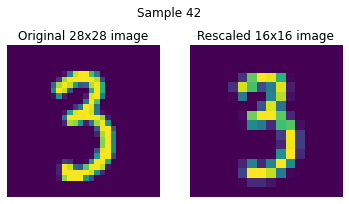

In [9]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, list_one, list_two, title_one, title_two):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(list_one[idx_to_plot])
    ax[0].set_title(title_one)
    ax[0].axis("off")
    ax[1].imshow(list_two[idx_to_plot])
    ax[1].set_title(title_two)
    ax[1].axis("off")
    fig.suptitle(f"Sample {idx_to_plot}",y=0.9)
    plt.show()
    
plot_comparison(42, 
                X_train, 
                X_train_small, 
                f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image")

In [10]:
# Replace X_train and X_test, for convenience
X_train = X_train_small
X_test = X_test_small

##### Normalization

In [11]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

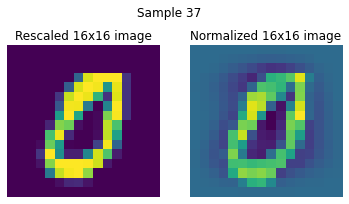

In [12]:
plot_comparison(37,
                X_train,
                X_train_norm,
                f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image")

In [13]:
# Replace X_train and X_test, for convenience
X_train = X_train_norm
X_test = X_test_norm

##### One-hot encoding

In [14]:
# Convert labels to one-hot encodings
def convert_to_onehot(labels):
    onehot = np.zeros((labels.size, labels.max()+1))
    onehot[np.arange(labels.size),labels] = 1
    return onehot
Y_train = convert_to_onehot(Y_train)
Y_test = convert_to_onehot(Y_test)

### Defining the set of operators and terminals

In [15]:
# Create set of functions and terminals, with one terminal for each pixel
pset = gp.PrimitiveSet("main", DESIRED_IMAGE_SIZE**2)

In [16]:
# Define operators (with a variable number of inputs)
def linear(*args):
    return sum(args)

def inverse(*args):
    return -sum(args)

def tanh(*args):
    return math.tanh(sum(args))

def sigmoid(*args):
    return 1.0/(1.0 + math.exp(-sum(args)))

def step(*args):
    return float(sum(args) >= 0)

def sine(*args):
    return math.sin(sum(args))

def cosine(*args):
    return math.cos(sum(args))

def gaussian(*args):
    return 0.5*sum(args)*(1.0+math.tanh(math.sqrt(2.0/math.pi)*(sum(args) + 0.044715*sum(args)**3)))
                          
def absolute(*args):
    return abs(sum(args))

In [17]:
# Hacky solution to allow variable arities
for arity in range(1, MAX_ARITY+1):
    pset.addPrimitive(linear, arity)
    pset.addPrimitive(inverse, arity)
    pset.addPrimitive(tanh, arity)
    pset.addPrimitive(sigmoid, arity)
    pset.addPrimitive(step, arity)
    pset.addPrimitive(sine, arity)
    pset.addPrimitive(cosine, arity)
    pset.addPrimitive(gaussian, arity)
    pset.addPrimitive(absolute, arity)

### Defining individuals

In [18]:
# Intialize the toolbox which will contain all sorts of functions for the genetic programming process
toolbox = base.Toolbox()

In [19]:
# Define how to create a random expression/tree (using half-and-half intialization)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)

In [20]:
# Define what an individual looks like (a list of trees)
class MulticlassIndividual:
    def __init__(self, contents):
        self.trees = [gp.PrimitiveTree(contents[i]) for i in range(N_CLASSES_TO_USE)]

# Define how to initialize an invidual (using a function that generates random expressions/trees)
def initialize_individual(individual, expr_func):
    return individual([expr_func() for i in range(N_CLASSES_TO_USE)])

In [21]:
# Create a class for fitness and a class for individuals
creator.create("Fitness", base.Fitness, weights=(-1.0,))
creator.create("Individual", MulticlassIndividual, fitness=creator.Fitness)

In [22]:
# Add the initialization of an individual and a population to the toolbox
toolbox.register("individual", initialize_individual, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [23]:
# Generate a population
pop = toolbox.population(POPULATION_SIZE)

### Fitness function

In [24]:
# Define how to compile a tree to a function
toolbox.register("compile", gp.compile, pset=pset)

In [25]:
def get_individual_outputs(individual, inputs):
    outputs = []
    for tree in individual.trees:
        outputs.append(toolbox.compile(expr=tree)(*inputs))
    return outputs

In [26]:
get_individual_outputs(pop[0], X_train[0].flatten())

[-4.3403953356145735, 0.7608750584622529, -0.8228075103439997, 1.0]